In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [125]:
def do_strat(days, days2, bound1, bound2):
    
    df = pd.read_excel('Datensätze.xlsx')
    df.replace(0, float('NaN'), inplace=True)
    df.dropna(subset = ["US10Y_Yield"], inplace=True)
    df.dropna(subset = ["Bond_P"], inplace=True)
    
    df['1D Return'] = np.log(df['Stock_P']/df['Stock_P'].shift(1))
    df['1M nReturn'] = np.log(df['Stock_P'].shift(-20)/df['Stock_P'])
    df['3M nReturn'] = np.log(df['Stock_P'].shift(-60)/df['Stock_P'])
    df['6M nReturn'] = np.log(df['Stock_P'].shift(-120)/df['Stock_P'])
    
    # Stock
    df['Stock_MA'] = df['Stock_P'].rolling(days).mean()
    df['Stock_Z'] = (df['Stock_P']-df['Stock_MA'])/df['Stock_P'].rolling(days).std()

    # Vola
    df['Stock_Vol_MA'] = df['Stock_Vol'].rolling(days).mean()
    df['Stock_Vol_Z'] = (df['Stock_Vol']-df['Stock_Vol_MA'])/df['Stock_Vol'].rolling(days).std()

    # Volume
    df['Stock_Volume_MA'] = df['Stock_Volume'].rolling(days).mean()
    df['Stock_Volume_Z'] = (df['Stock_Volume']-df['Stock_Volume_MA'])/df['Stock_Volume'].rolling(days).std()

    # Bond
    df['Bond_P'] = df['Bond_P']*-1
    df['Bond_MA'] = df['Bond_P'].rolling(days).mean()
    df['Bond_Z'] = (df['Bond_P']-df['Bond_MA'])/df['Bond_P'].rolling(days).std()

    # Put_Call_Ratio
    df['Put_Call'] = df['Put_Call']*-1
    df['Put_Call_MA'] = df['Put_Call'].rolling(days).mean()
    df['Put_Call_Z'] = (df['Put_Call']-df['Put_Call_MA'])/df['Put_Call'].rolling(days).std()

    # Earnings Yield Spread 
    df['Earnings_Yield_Spread'] = ((df['Earnings']/df['SPX_P']) - df['US10Y_Yield'])*-1
    df['Earnings_Yield_Spread_MA'] = df['Earnings_Yield_Spread'].rolling(days2).mean()
    df['Earnings_Yield_Spread_Z'] = (df['Earnings_Yield_Spread']-df['Earnings_Yield_Spread_MA'])/df['Earnings_Yield_Spread'].rolling(days2).std()
    df['Earnings_Yield_Spread_Sell'] = df['Earnings_Yield_Spread_Z'] < -bound2

    # Put vs Call Demand (hoch heisst Greed (mehr Calls))
    df['SPX_Impl_Spread_P-C_MA'] = (1/df['SPX_Impl_Spread_P-C']).rolling(days).mean()
    df['SPX_Impl_Spread_P-C_Z'] = ((1/df['SPX_Impl_Spread_P-C'])-df['SPX_Impl_Spread_P-C_MA'])/(1/df['SPX_Impl_Spread_P-C']).rolling(days).std()

    # Index
    df['Score'] = 0.25*(df['Stock_Z']/3)+0.25*(df['Stock_Vol_Z']/-3)+0.25*(df['Bond_Z']/-3)+0.25*(df['Put_Call_Z']/-3)
    df.dropna(subset = ["Score"], inplace=True)
    df.dropna(subset = ["6M nReturn"], inplace=True)
#     df['BUY'] = df['Score'] < -bound1
#     df['SELL'] =  (df['Score'] > bound1) & (df['Earnings_Yield_Spread_Z'] < - bound2)
    
    # Calculate returns 
#     df['rb6'] = df.BUY * df['6M nReturn'] 
#     df['rs6'] = df.SELL * -df['6M nReturn']
    
#     df['rb3'] = df.BUY * df['3M nReturn'] 
#     df['rs3'] = df.SELL * -df['3M nReturn']
    
#     buy_amount = df["BUY"].sum()
#     buy_return6 = df["rb6"].sum()/buy_amount
#     buy_return3 = df["rb3"].sum()/buy_amount
#     sell_amount = df["SELL"].sum()
#     sell_return6 = df["rs6"].sum()/sell_amount
#     sell_return3 = df["rs3"].sum()/sell_amount
    
    return df

# buy_amount, buy_return6, buy_return3, sell_amount, sell_return6, sell_return3

In [5]:
result = pd.DataFrame(columns = ['period', 
                                 'bound1', 
                                 'bound2', 
                                 '# bought', 
                                 '6M Breturn', 
                                 '3M Breturn',
                                 '# sold', 
                                 '6M Sreturn',
                                 '3M Sreturn']
                     )

n=0
for i in np.linspace(120, 360, 12):
    for k in np.linspace(120, 360, 12):
        for j in np.linspace(0.1,1,10):
            for l in np.linspace(0.2, 3, 11):
                buy_amount, buy_return6, buy_return3, sell_amount, sell_return6, sell_return3 = do_strat(int(i),int(k), j, l)
                result = result.append(pd.Series([0,0,0,0,0,0,0]), ignore_index=True)
                result.iloc[n, 0] = i
                result.iloc[n, 1] = k 
                result.iloc[n, 2] = j 
                result.iloc[n, 3] = l 
                result.iloc[n, 4] = buy_amount 
                result.iloc[n, 5] = buy_return6
                result.iloc[n, 6] = buy_return3 
                result.iloc[n, 7] = sell_amount 
                result.iloc[n, 8] = sell_return6 
                result.iloc[n, 9] = sell_return3
                n+=1

KeyboardInterrupt: 

In [73]:
result.to_excel('finish.xlsx')

Sell Return is 0.049 on average from 8 trades
Buy Return is 0.03 on average from 13 trades
The Average 1M Return is 0.01


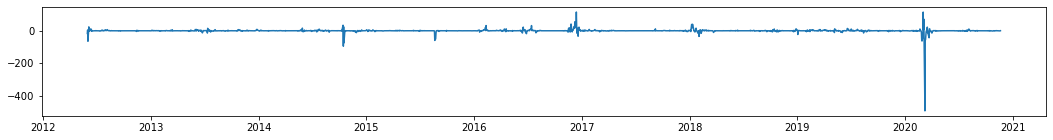

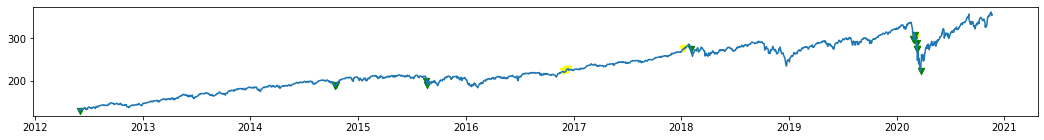

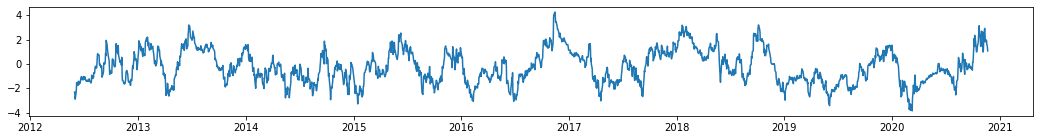

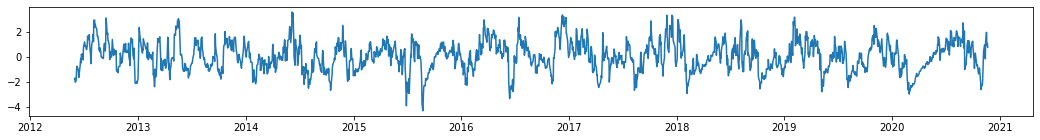

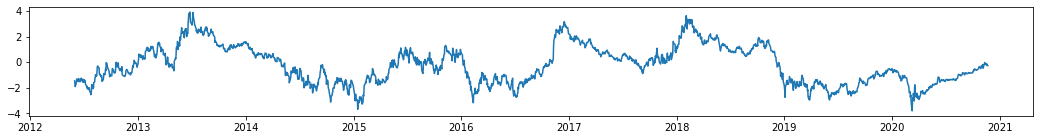

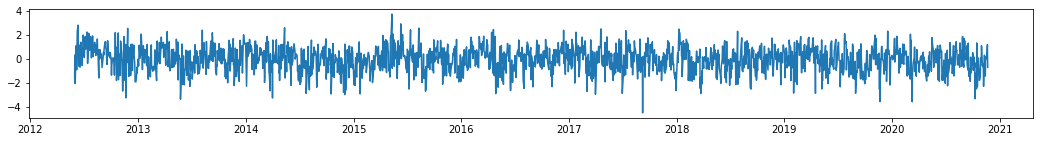

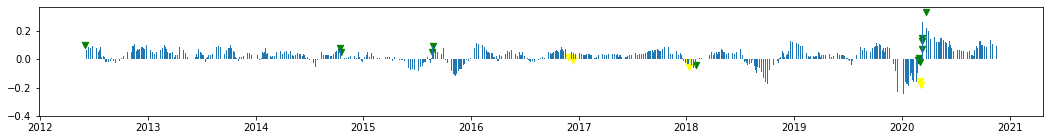

In [126]:
df = do_strat(80, 240, 0.8, 0.8)

b = 35

df['Score_new'] = df['Stock_Z']*df['Bond_Z']*df['SPX_Impl_Spread_P-C_Z']*df['Earnings_Yield_Spread_Z']*df['Put_Call_Z']
df.dropna(subset=['Score_new'], inplace=True)
df['SELL'] = df['Score_new'] > b 
df['BUY'] = df['Score_new']< -b

print(f"Sell Return is {round(((df['1M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum()),3)} on average from {df['SELL'].sum()} trades")
print(f"Buy Return is {round(((df['1M nReturn']*df['SELL']*-1).sum()/df['BUY'].sum()),3)} on average from {df['BUY'].sum()} trades")
print(f"The Average 1M Return is {round(df['1M nReturn'].sum()/df['1M nReturn'].count(), 3)}")

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Score_new'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Stock_P'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='yellow', s=40, marker="v")
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=40, marker="v")
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Bond_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['SPX_Impl_Spread_P-C_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Earnings_Yield_Spread_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Put_Call_Z'])
plt.show()

plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['3M nReturn'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '1M nReturn'].values, label='skitscat', color='yellow', s=40, marker="v")
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '3M nReturn'].values, label='skitscat', color='green', s=40, marker="v")
plt.show()

<ipython-input-17-d2c8c3a4548c>:61: RuntimeWarning: invalid value encountered in double_scalars
  sell_return6 = df["rs6"].sum()/sell_amount
<ipython-input-17-d2c8c3a4548c>:62: RuntimeWarning: invalid value encountered in double_scalars
  sell_return3 = df["rs3"].sum()/sell_amount


In [128]:
df.columns

Index(['Date', 'Fwd_Earnings', 'Stock_P', 'Stock_Vol', 'US10Y_Yield',
       'Put_Call', 'SPX_P', 'Bond_P', 'Earnings', 'Stock_Volume',
       'SPX_Impl_Spread_P-C', 'Dollar ', 'Vola_Slope', 'HY_CDS', '1D Return',
       '1M nReturn', '3M nReturn', '6M nReturn', 'Stock_MA', 'Stock_Z',
       'Stock_Vol_MA', 'Stock_Vol_Z', 'Stock_Volume_MA', 'Stock_Volume_Z',
       'Bond_MA', 'Bond_Z', 'Put_Call_MA', 'Put_Call_Z',
       'Earnings_Yield_Spread', 'Earnings_Yield_Spread_MA',
       'Earnings_Yield_Spread_Z', 'Earnings_Yield_Spread_Sell',
       'SPX_Impl_Spread_P-C_MA', 'SPX_Impl_Spread_P-C_Z', 'Score', 'Score_new',
       'SELL', 'BUY'],
      dtype='object')

In [59]:
do_strat(df, 120, 0.1, 0.1)

(493,
 0.08779170776976371,
 0.06159338147416765,
 1066,
 -0.04435406150102237,
 -0.012530798798757051)

In [42]:
for i in range(1,len(df['Score_new'])):
    print(df['Score_new'].iloc[i])

0.06251631019282972
0.17996842498831908
0.3042746731280519
0.048221488045398025
-0.05075071109113148
0.037219095669169255
1.1889044230322773e-05
-0.0542379863700617
0.008927713938129222
-0.0818858283910233
-0.5396300859749122
0.2134229571288105
0.01354443676414557
0.25973236344251344
0.5694666425289935
0.05130072105180209
0.33854546328968826
-0.15735249257723927
0.6143510498302351
1.1043597852162341
0.4804338317628154
0.9924242974958596
0.3180593745999443
0.19858813322825203
1.5467238252199154
1.1250986816282076
1.5690448563981605
6.41050091990048
2.3746000229673228
2.913382470766263
2.4646572798790904
0.5323219185396783
-0.18203148021208612
0.046331264169764935
2.09162861592195
-0.5388345739035058
4.04674761841401
5.435773743488631
7.040563609913297
16.81097336737844
6.683475705263351
9.509231815427041
1.8188169180975333
2.45072907133395
0.5949487586363856
-0.21532219621525306
0.01933839763508243
-0.15572646504411242
-0.35503286006430457
-0.461834539382691
0.20905441470425884
-0.05898

-0.1285100831452754
-0.04872763958857439
-0.1961423507116935
-0.9471478662683471
0.12861680019629293
0.9008685711426092
0.08973600389912467
0.1787046431843513
0.0026231092610149746
-0.07723815825580246
-0.0029120860591952745
0.005909623321866676
0.005391774448410897
-0.0337789226529718
0.01870907571388049
0.011108697314824677
0.01508590564876591
0.0073680356529657876
0.014205490435902943
0.04000054208831683
0.030445975839657018
0.0012885616693420082
0.006668335115267106
0.00369681735492614
-0.07205101302198523
-0.028792037947236004
-0.04051077157180168
-0.042115052516187405
0.21340922723214675
0.2150965439023536
0.0720038096619772
0.08780599736514037
0.014204715913537804
0.10842934913771406
0.01808542540927182
0.09788208578993518
-0.0053491167764150175
-0.009799326682654185
-0.06106142556934953
0.03319808051103173
0.043137176932806776
-0.02562324230565849
0.009677572376883442
-0.13147812685787172
0.06586319511857977
-0.0012824723455811728
0.16074109889487964
-0.039047448347430576
0.045

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 5.000e+00,
        2.700e+01, 2.162e+03, 3.000e+01, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([-609.36314153, -585.35430451, -561.34546749, -537.33663047,
        -513.32779346, -489.31895644, -465.31011942, -441.3012824 ,
        -417.29244538, -393.28360837, -369.27477135, -345.26593433,
        -321.25709731, -297.24826029, -273.23942328, -249.23058626,
        -225.22174924, -201.21291222, -177.2040752 , -153.19523819,
        -129.18640117, -105.17756415,  -81.16872713,  -57.15989011,
         -33.15105309,   -9.14221608,   14.86662094,   38.87545796,
          62.88429498,   86.893132  ,  110.90196901]),
 <BarContainer object of 30 artists>)

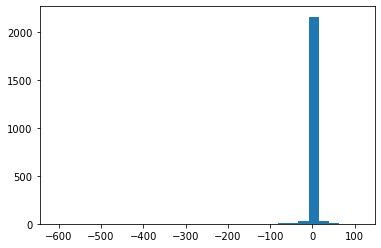

In [44]:
plt.hist(df['Score_new'],bins=30)

In [56]:
(df['6M nReturn']*df['SELL']).sum()

3.679352145260907

In [104]:
df['1M nReturn'].sum()/df['1M nReturn'].count()

0.00964209056034645

In [107]:
df['1M nReturn'].sum()

20.421947806813783